# Машинное обучение, ФКН ВШЭ

# Семинар 4

In [67]:
%pylab inline
import matplotlib.pylab as plt
import math
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [68]:
#from google.colab import drive
#drive.mount('/content/drive')

## Линейная классификация

Ранее мы изучили задачу восстановления регрессии и способы её решения. В частности, для линейной модели с функционалом качества MSE решение данной задачи выписывается аналитически через матрицу "объект-признак" и вектор ответов обучающей выборки.

Давайте приступим к рассмотрению задачи классификации. Начнём с того, что вспомним её постановку.

### Постановка задачи классификации

Пусть задана обучающая выборка $X = \left\{ \left( x_i, y_i \right) \right\}_{i=1}^l, x_i \in \mathbb{X}, y_i \in \mathbb{Y},$ — $l$ пар объект-ответ, где
$\mathbb{X}$ — пространство объектов,
$\mathbb{Y}$ — пространство ответов.

Задача классификации отличается о задачи восстановления регрессии тем, что в данном случае пространство ответов конечно:
$$\left| \mathbb{Y} \right| < \infty.$$


**Примеры**:

1) Кредитный скоринг.
* Объект — заявка на кредит от клиента банка.
* Ответ — решение о выдаче или невыдаче кредита.

2) Медицинская диагностика.
* Объект — характеристики пациента (результаты анализов, общая информация о пациенте, история болезни).
* Ответ — диагноз (одно из ограниченного множества заболеваний).

В дальнейшем будем рассматривать задачу бинарной классификации (то есть разделения объектов на 2 группы) и полагать $\mathbb{Y} = \{-1, +1\}.$

### Линейная модель

Сегодня мы будем рассматривать линейную модель. В случае классификации формула для ответа на объекте $x$ видоизменяется по сравнению с линейной регрессией (при этом мы предполагаем, что нулевой признак в выборке — константный):
$$a(x) = sign(w_0 \cdot 1 + w_1 x_1 + \dots w_d x_d) = sign(\sum_{j = 0}^d w_j x_j) = sign(\langle w, x \rangle).$$

Множество точек $\langle w, x\rangle = 0$ является гиперплоскостью и делит пространство на 2 части по разные стороны от этой самой гиперплоскости. При этом объекты, расположенные по разные стороны от неё, полученный классификатор относит к различным классам в зависимости от знака скалярного произведения.

<tr>
<td> <img src="images/plane.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="images/cube.png" alt="Drawing" style="width: 350px;"/> </td>
</tr>

Отметим, что для некоторого объекта $x$ расстояние до гиперплоскости для фиксированного вектора весов $w$ можно записать как $\frac{\left| \langle w, x \rangle \right|}{\|w \|}$.

Поэтому чем больше $\left| \langle w, x \rangle \right|$, тем дальше объект отстоит от гиперплоскости, тем увереннее алгоритм в его классификации.

### Оптимизируемый функционал

Как и в случае линейной регрессии, поиск оптимального алгоритма среди множества всех линейных моделей в случае классификации производится путем оптимизации некоторого функционала. Можно было бы рассматривать MAE или MSE, как и в случае регрессии, однако в случае классификации этот подход кажется немного странным, как минимум, потому что классы могут задаваться своими названиями, а не номерами. Их можно было бы занумеровать, но тогда результат будет сильно зависеть от способа нумерации.

Будем минимизировать долю неверных классификаций, которую можно записать в следующем виде:

$$Q(w, X) = \frac{1}{l} \sum_{i = 1}^l [a(x_i) \ne y_i] \to \min_w.$$

В этом функционале слагаемое $[a(x_i) \ne y_i]$ отвечает за то, была ли допущена алгоритмом $a(\cdot)$ ошибка на объекте $x_i$.

Заметим, что $[a(x_i) \ne y_i] = [sign \, \langle w, x_i \rangle \ne sign \, y_i] = [y_i \langle w, x_i \rangle < 0],$ поэтому функционал можно переписать в следующем виде:
$$Q(w, X) = \frac{1}{l} \sum_{i = 1}^l [y_i \langle w, x_i \rangle  < 0] \to \min_w.$$

Величина $M_i = y_i \langle w, x_i \rangle$ называется **отступом** объекта $x_i$. Как было показано ранее:
* объект верно классифицируется тогда и только тогда, когда отступ положительный;
* чем больше значение отступа, тем надёжнее классифицируется объект.

Тем не менее, получившийся функционал не получится оптимизировать градиентными методами. Поэтому рассмотрим пороговую функцию потерь для одного объекта $L(M) = [M < 0],$ участвующую в формуле функционала, оценим её сверху некоторой гладкой функцией потерь и будем минимизировать её:

$$Q(w, X) = \frac{1}{l} \sum_{i = 1}^l [M_i < 0] = \frac{1}{l} \sum_{i = 1}^l L(M_i) \le \frac{1}{l} \sum_{i = 1}^l \widetilde{L}(M_i) = \widetilde{Q}(w, X) \to \min_{w}$$

Примеры оценок сверху для одного объекта:
<img src="images/est.png" alt="Drawing" style="width: 650px;">

**ВАЖНО**: мы минимизируем верхнюю оценку и надеемся, что тогда будет минимизироваться и исходный функционал $Q(w, X)$, однако нет никаких гарантий, что так и будет!

В зависимости от выбранной верхней оценки будут меняться свойства итогового алгоритма, положение разделяющей гиперплоскости и т.п.

### Итог

Таким образом, процесс обучения линейного классификатора складывается из следующих шагов:

* Получение обучающей выборки $X = \{ \left( x_i, y_i \right) \}_{i=1}^l$
* Выбор верхней оценки для пороговой функции потерь — отсюда получаем общий вид оптимизируемого функционала $\widetilde{Q}(w, X^l)$
* Проводим оптимизацию при помощи некоторого метода оптимизации и получаем оптимальное значение $w^*$
* Предсказываем ответы для новых объектов по формуле $a(x) = \langle w^*, x\rangle$

### Логистическая регрессия

Рассмотрим в качестве верхней оценки пороговой функции потерь логистическую функцию:

$$\widetilde{L}(M) = \log_2(1 + \exp(-M)).$$

Таким образом, необходимо решить следующую оптимизационную задачу:
$$\frac{1}{l} \sum_{i=1}^l \widetilde{L} (M_i) = \frac{1}{l} \sum_{i=1}^l \log_2 (1 + \exp (-y_i \langle w, x_i \rangle)) \to \min_w$$

Получившийся метод обучения называется **логистической регрессией**.

Одно из полезных свойств логистической регрессии, которое будет изучено нами несколько позднее, — тот факт, что она позволяет предсказывать помимо метки класса ещё и вероятность принадлежности каждому из них, что может быть полезным в некоторых задачах.

**Пример**: Вы работаете в банке и хотите выдавать кредиты только тем клиентам, которые вернут его с вероятностью не меньше 0.9.

### Пример обучения логистической регрессии
#### Определение спама по тексту электронного письма

Попробуем при помощи моделей линейной классификации построить алгоритм, отделяющий спам от нормальной почты. Для экспериментов воспользуемся небольшим набором данных с [UCI](https://archive.ics.uci.edu/ml/datasets.html). Объекты в датасете соответствуют письмам, которые описаны признаками на основе текста письма, спам — положительный пример для классификации, хорошее письмо — отрицательный пример.

![Spam](./images/spam.jpg)

In [69]:
import pandas as pd
from urllib.request import urlopen

SPAMBASE_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
SPAMBASE_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

# Read feature names
feature_names = [
    line.strip().split(':')[0]
    for line in urlopen(SPAMBASE_NAMES_URL).read().decode('utf-8').splitlines()[33:]
]

# Load the dataset
spam_data = pd.read_csv(SPAMBASE_DATA_URL, header=None, names=(feature_names + ['spam']))

# Split into features (X) and target (y)
X = spam_data.iloc[:, :-1].values  # Use .iloc instead of deprecated .ix
y = spam_data.iloc[:, -1].values

# Display the first few rows
spam_data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Обучение логистической регрессии

Разделим выборку на обучающую и тестовую в отношении 80/20 и обучим логистическую регрессию при помощи объекта [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [70]:
from sklearn.linear_model import LogisticRegression

# splitting data
train_part = 0.8
n_train = int(train_part * X.shape[0])
X_tr = X[:n_train]
X_test = X[n_train:]
y_tr = y[:n_train]
y_test = y[n_train:]

# training
lr = LogisticRegression()
lr = lr.fit(X_tr, y_tr)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Оценим долю верных прогнозов полученной модели (accuracy) при помощи соответствующей функции из модуля [sklearn.metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [71]:
from sklearn import metrics

preds = lr.predict(X_test)

print('Accuracy =', metrics.accuracy_score(y_test, preds))

Accuracy = 0.7785016286644951


Сгенерируем двумерную искуственную выборку из 2 различных нормальных распределений:

<ipython-input-72-df3fc8ce0a14>:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data1 = np.random.multivariate_normal(mean1, cov1, 1000)


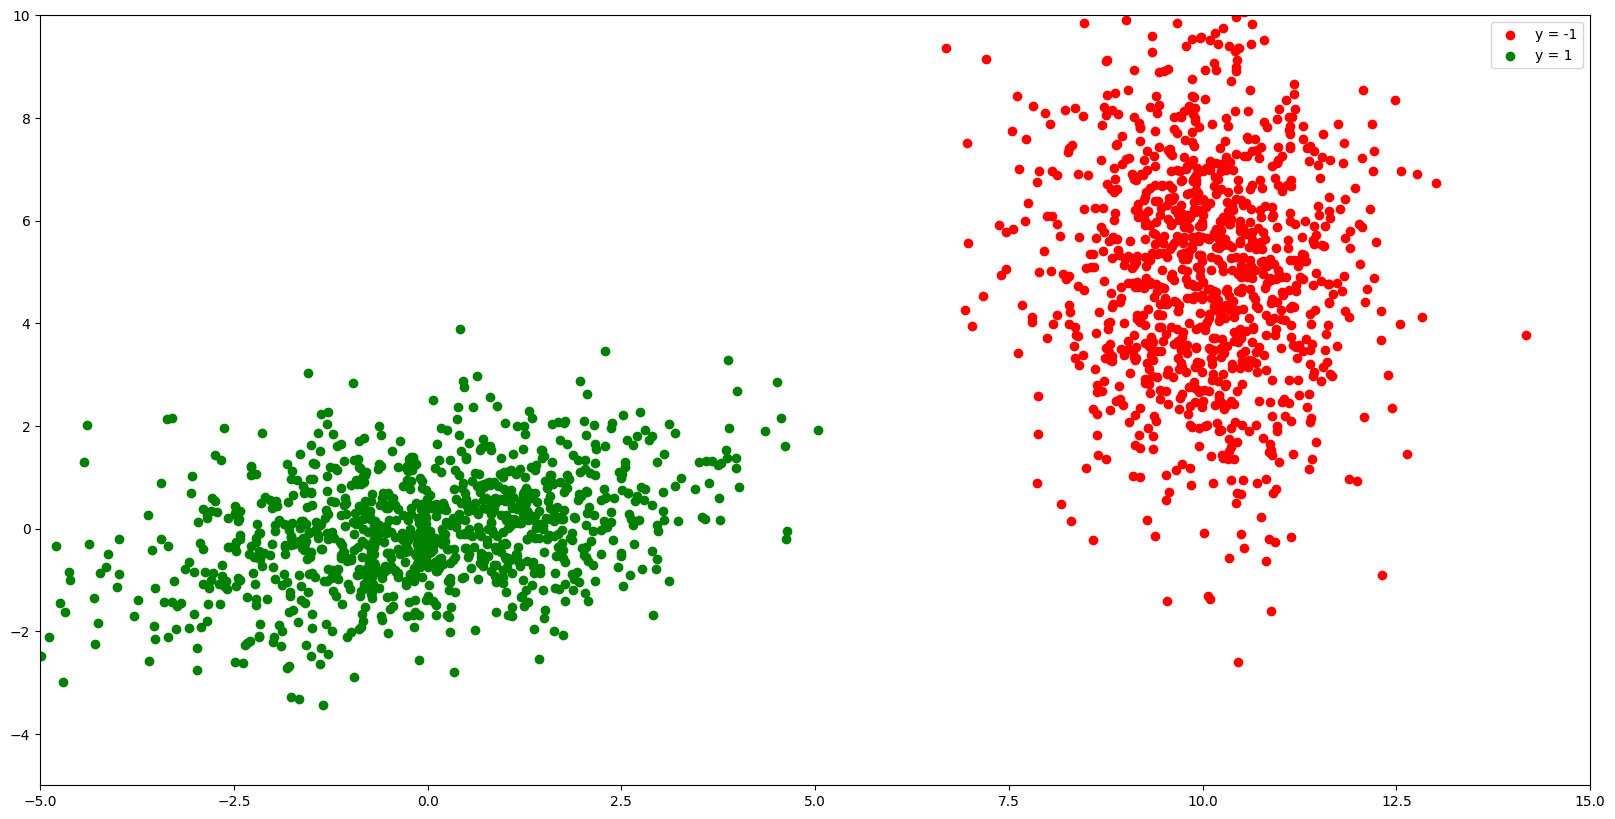

In [72]:
plt.figure(figsize=(20,10))
mean0 = [10, 5]
cov0 = [[1, 0], [0, 5]]  # diagonal covariance
data0 = np.random.multivariate_normal(mean0, cov0, 1000)
mean1 = [0, 0]
cov1 = [[3, 1], [0, 1]]
data1 = np.random.multivariate_normal(mean1, cov1, 1000)
data = np.vstack((data0, data1))
y_vis = np.hstack((-np.ones(1000), np.ones(1000)))


plt.scatter(data0[:, 0], data0[:, 1], c='red')
plt.scatter(data1[:, 0], data1[:, 1], c='green')
plt.legend(['y = -1', 'y = 1'])
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.show()

Обучим логистическую регрессию:

In [73]:
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(data, y_vis, test_size=0.2)

from sklearn import linear_model

logreg = linear_model.LogisticRegression(penalty = 'l2')
logreg.fit(X_train_vis, y_train_vis)

LogisticRegression()

Полученные в результате оптимизации коэффициенты линейной модели содержатся в атрибутах coef\_ и intercept\_ соответствующего объекта. Визуализируем разделяющую гиперплоскость алгоритма и рассмотрим значения предсказанных моделью вероятностей принадлежности нового объекта каждому из классов в зависимости от его координат.

In [74]:
print(logreg.coef_, logreg.intercept_)

[[-1.99142338 -0.5512708 ]] [12.97700826]


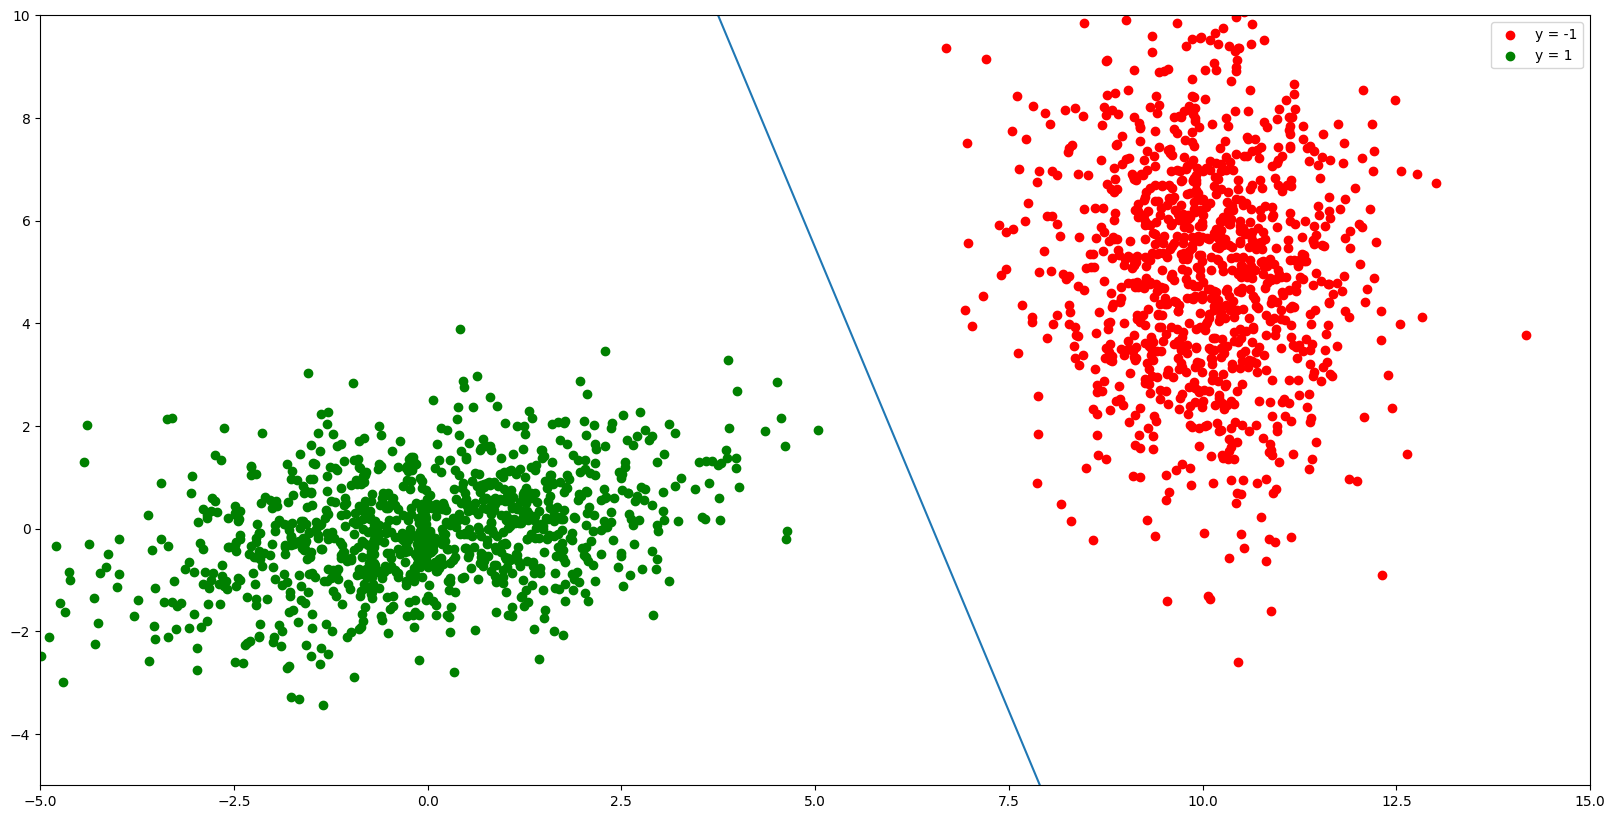

In [75]:
w_1 = logreg.coef_[0][0]
w_2 = logreg.coef_[0][1]
w_0 = logreg.intercept_[0]


plt.figure(figsize=(20,10))
plt.scatter(data0[:, 0], data0[:, 1], c='red')
plt.scatter(data1[:, 0], data1[:, 1], c='green')
plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-10, 15, 3000)
plt.plot(x_arr, -(w_0 + w_1 * x_arr) / w_2)
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.show()

P(y = -1|x) = 0.9996777198668201
P(y = 1|x) = 0.00032228013317987504


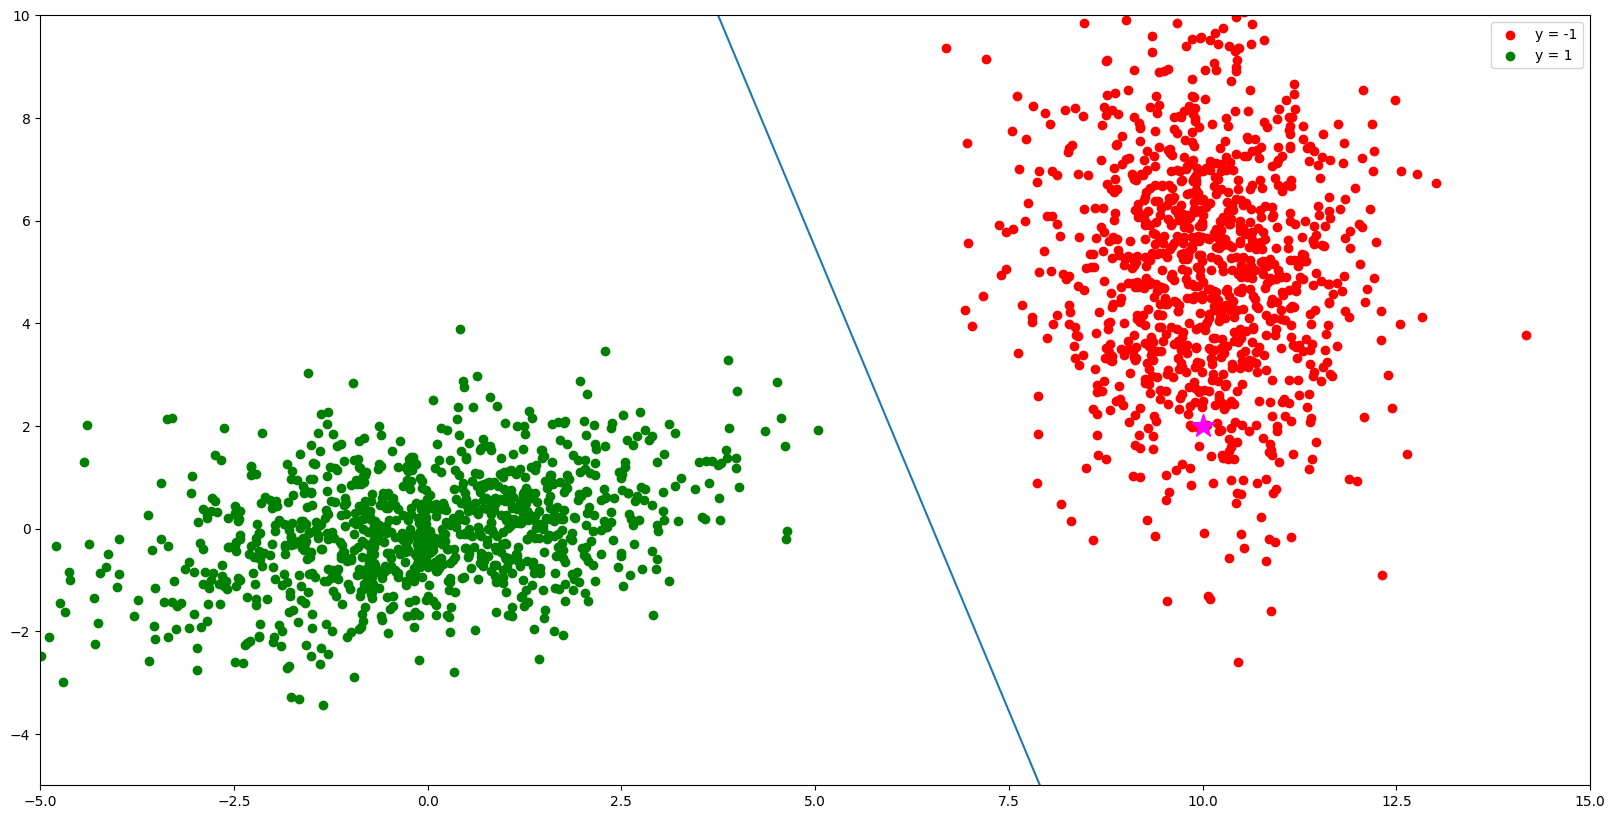

In [76]:
point = np.array([[10, 2]]) # изменяем только координаты объекта

plt.figure(figsize=(20,10))
plt.scatter(data0[:, 0], data0[:, 1], c='red')
plt.scatter(data1[:, 0], data1[:, 1], c='green')
plt.scatter(point[:, 0], point[:, 1], marker = '*', s = 300, color = 'magenta')
plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-10, 15, 3000)
plt.plot(x_arr, -(w_0 + w_1 * x_arr) / w_2)
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
prob = logreg.predict_proba(point)
print('P(y = -1|x) =', prob[0][0])
print('P(y = 1|x) =', prob[0][1])
plt.show()

### SGDClassifier

Объект [SGDClissifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) позволяет обучать линейные модели классификации и регрессии с помощью стохастического градиентного спуска.

Полезные параметры:
* loss - функция потерь (по факту то, какую модель обучаем): **hinge** (SVM), **log** (логистическая регрессия), **perceptron** (персептрон) и другие;
* penalty - тип регуляризации: **l1**, **l2**, **elasticnet** (смесь l1 и l2 регуляризации);
* alpha - коэффициент регуляризации;
* fit_intercept - необходимо ли добавлять в модель свободный член (True/False);
* n_iter - число эпох (полных проходов по выборке) при обучении;
* learning_rate - шаг градиентного спуска (оптимизируется по умолчанию).

In [77]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

lr_sgd = SGDClassifier(
    loss="log_loss",  # or "log" in older versions
    alpha=0.05,
    max_iter=200,     # Replaces 'n_iter'
    fit_intercept=True,
    random_state=42   # For reproducibility
)

lr_sgd.fit(X_tr, y_tr)
preds_sgd = lr_sgd.predict(X_test)

print('Accuracy =', metrics.accuracy_score(y_test, preds_sgd))

Accuracy = 0.26275787187839306


## Оценка качества работы классификатора
### Бинарные метрики
Обучение и оценка качества модели производится на независимых множествах примеров. Как правило, имеющующиеся примеры разбивают на два подмножества: обучение (`train`) и контроль (`test`). Выбор пропорции разбиения — компромисс: большой размер обучения ведет к более богатым информацией и качественным алгоритмам, большой размер контрольной выборки ведет к менее шумной оценке качества.

Для оценки качества классификации рассматривают [матрицу ошибок](http://en.wikipedia.org/wiki/Confusion_matrix): строчки соответствуют прогнозу модели, столбцы — истинным ответам, ячейки содержат число примеров тестовой выборки. Если для некоторого алгоритма $a(\cdot)$ и объекта $x$ выполняется $a(x) = 1$, то говорят, что алгоритм $a$ _выделяет_ объект $x$.

| | y = +1 | y = -1 |
|------|------|
|   **a(x) = +1**  | TP| FP |
| **a(x) = -1**| FN | TN |

Диагональ матрицы ошибок содержит правильно классифицированные положительные (TP) и отрицательные (TN) примеры. False Positive (FP) — ошибки I рода (ложное срабатывание, положили в спам хорошее письмо), False Negative (FN) — ошибки II рода (не отфильтровали спам). Ошибки I и II рода могут иметь различную стоимость.

Часто рассматриваются следующие метрики качества бинарной классификации:
  - Доля правильных ответов (Accuracy):
  $$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
  - Точность/precision (доля действительно положительных объектов среди объектов, выделенных алгоритмом):
  $$precision = \frac{TP}{TP + FP}$$
  - Полнота/recall (доля выделенных алгоритмом объектов среди всех положительных объектов выборки):
  $$recall = \frac{TP}{TP + FN}$$
  - $F_1$-мера (среднее гармоническое между точностью и полнотой)
  $$F_1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$$
  
Подробнее про метрики качества бинарной классификации на Википедии: [Precision and Recall](http://en.wikipedia.org/wiki/Precision_and_recall).

### Выбор порога классификации
Многие модели классификации получают оценку принадлежности положительному классу $b(x) \in \mathbb{R}$, после чего принимается решение о классификации объекта путем сравнения оценки с некоторым порогом:

$a(x) = \begin{cases}
        +1, \, b(x) \ge t,\\
        -1, \, b(x) < t.
        \end{cases}$
        
Матрица ошибок и все производные от нее метрики (Accuracy, Precision, Recall, etc.) зависят от порога $t$:
![Порог классификации](./images/binary_threshold.png)

Поскольку иногда необходимо оценить качество модели $b(x),$ предсказывающей не конкретную метку класса, а степень принадлежности классу (т.е. вне зависимости от значения порога), рассматривают координатную плоскость, по осям которой отложены значения метрик, а качество работы классификатора представлено в виде кривой — траектории изменения соответствующих метрик при варьировании порога:
![Принцип построения ROC-кривой](./images/roc_trajectory.png)

Наиболее распространены ROC-кривые и Precision/Recall кривые.
 - По осям Ox и Oy ROC-кривой отложены соответственно False Positive Rate (FPR) и True Positive Rate (TPR):
 $$FPR = \frac{FP}{FP + TN},$$
 $$TPR = \frac{TP}{FN + TP}.$$
 - По осям Ox и Oy PR-кривой отложены соответственно Recall и Precision.


Аббревиатура ROC ([Receiver Operating Characteristic](en.wikipedia.org/wiki/Receiver_operating_characteristic)) была унаследована из инженерного дела.

![Примеры ROC-кривых](./images/roc_and_pr_curves.png)

В случае, если необходимо сравнить качество классификаторов вне зависимости от порога, применяют интегральные числовые метрики, например AUC-ROC (**A**rea **U**nder RO**C**) — площадь под ROC-кривой классификатора. AUC-ROC идеально работающего классификатора равно 1. Идеальный случайный классификатор в среднем имеет AUC-ROC=0.5.

Построим описанные кривые для логистической регрессии, обученной на описанном выше датасете.

* PR-кривая проходит через точку (0,0).

* Если при каком-то значении порога $t$ алгоритм $a(x)$ идеально разделяет объекты 2 классов, то PR-кривая проходит через точку (1,1).


In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train_curve, X_test_curve, y_train_curve, y_test_curve = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_curve, y_train_curve)

y_pred = lr.predict(X_test_curve)
print("Accuracy:", metrics.accuracy_score(y_test_curve, y_pred))

Accuracy: 0.9229098805646037


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
from sklearn.metrics import precision_recall_curve

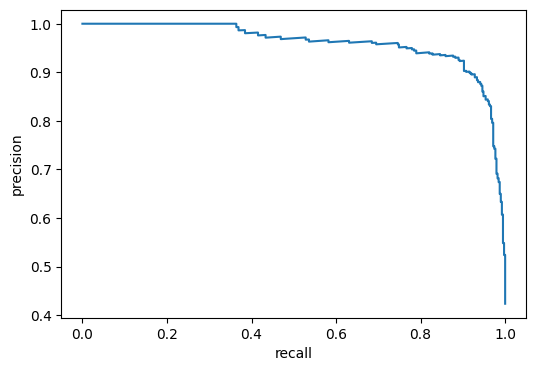

In [80]:
precision, recall, thresholds = precision_recall_curve(y_test_curve, lr.predict_proba(X_test_curve)[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [81]:
from sklearn.metrics import auc

auc(recall, precision)

np.float64(0.9596718239205722)

* ROC проходит через точки (0,0) и (1,1)
* Если при каком-то значении порога $t$ алгоритм $a(x)$ идеально разделяет объекты 2 классов, то ROC проходит через точку (0,1).


In [82]:
from sklearn.metrics import roc_curve

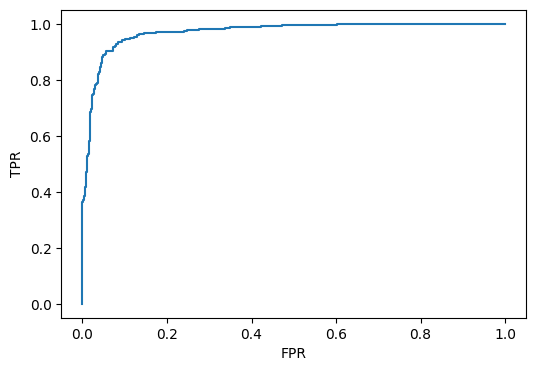

In [83]:
fpr, tpr, thresholds = roc_curve(y_test_curve, lr.predict_proba(X_test_curve)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [84]:
auc(fpr, tpr)

np.float64(0.9701579023612922)

## Валидация
Чтобы оценить качество работы алгоритма, необходимо провести валидацию. Это один из самых важных шагов в процессе решения задачи. Оценим accuracy для модели логистической регрессии в задаче про спам-письма на тестовой выборке.

In [85]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Загрузка данных
spam_data = pd.read_csv(SPAMBASE_DATA_URL, header=None, names=(feature_names + ['spam']))

# Разделение на признаки (X) и целевую переменную (y)
X = spam_data.iloc[:, :-1].values  # Все строки, все столбцы кроме последнего
y = spam_data.iloc[:, -1].values   # Все строки, только последний столбец

# Разделение на обучающую и тестовую выборки
n_train = int(0.8 * len(X))  # 80% данных для обучения
X_tr = X[:n_train]
y_tr = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

# Обучение логистической регрессии
lr = LogisticRegression(max_iter=1000)  # Увеличиваем max_iter для сходимости
lr.fit(X_tr, y_tr)

# Оценка точности
preds = lr.predict(X_test)
print('Accuracy =', metrics.accuracy_score(y_test, preds))

Accuracy = 0.8175895765472313


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


А теперь попробуем перемешать объекты и повторим действия:

In [86]:
# Добавляем масштабирование данных
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Теперь разделяем масштабированные данные
X_tr, X_test, y_tr, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=123)

# Обучение с увеличенным количеством итераций
lr = LogisticRegression(max_iter=1000)
lr.fit(X_tr, y_tr)

# Оценка
preds = lr.predict(X_test)
print('Accuracy = {:.2f}%'.format(100 * metrics.accuracy_score(y_test, preds)))

Accuracy = 93.70%


Как мы видим, качество классификации новых данных резко возросло. С чем это может быть связано? Рассмотрим вектор целевой переменной:

Text(0, 0.5, 'Target')

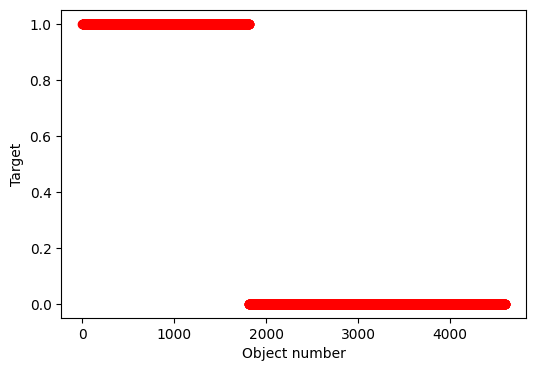

In [87]:
plt.plot(y, 'ro')
plt.xlabel('Object number')
plt.ylabel('Target')

Проблема заключалась в том, что в выборке примеры были упорядочены: сначала шли примеры положительного класса, а потом отрицательного. Поэтому нельзя забывать **перемешивать классы**.

Чтобы повысить устойчивость оценки качества, можно проводить разбиение выборки на обучающую и тестовую не один, $N$ раз, после чего усреднять результаты, полученные на $N$ контрольных выборках. Для этого можно использовать функцию [`sklearn.cross_validation.ShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.ShuffleSplit.html#sklearn.cross_validation.ShuffleSplit)

In [88]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Создание ShuffleSplit с уменьшенным количеством разбиений для демонстрации
cv = ShuffleSplit(n_splits=5, train_size=0.9, test_size=0.1, random_state=123)

quals = []
# 3. Настройка логистической регрессии с оптимальными параметрами
lr = LogisticRegression(
    max_iter=5000,        # Увеличиваем количество итераций
    solver='lbfgs',       # Оптимальный solver для большинства случаев
    penalty='l2',         # L2 регуляризация
    C=1.0,               # Сила регуляризации (меньше значение -> сильнее регуляризация)
    random_state=123,    # Для воспроизводимости
    n_jobs=-1            # Использовать все ядра процессора
)

for tr_ind, test_ind in cv.split(X_scaled):
    # 4. Обучение на масштабированных данных
    lr.fit(X_scaled[tr_ind], y[tr_ind])

    # 5. Предсказание вероятностей
    proba = lr.predict_proba(X_scaled[test_ind])[:, 1]

    # 6. Расчет ROC-AUC
    quals.append(metrics.roc_auc_score(y[test_ind], proba))

# 7. Вывод статистики
print(f"Mean ROC-AUC: {np.mean(quals):.4f} ± {np.std(quals):.4f}")
print(f"All ROC-AUC scores: {quals}")

Mean ROC-AUC: 0.9732 ± 0.0078
All ROC-AUC scores: [np.float64(0.981070881000118), np.float64(0.9768250972992099), np.float64(0.9767945665326514), np.float64(0.9728524335854181), np.float64(0.9584885257719572)]


In [89]:
print('Mean AUC-ROC =', np.mean(quals))
print('AUC-ROC standart deviation =', np.std(quals))

Mean AUC-ROC = 0.973206300837871
AUC-ROC standart deviation = 0.007804627916518988


Увеличим $N$:

In [90]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np

# Масштабирование данных для лучшей сходимости
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создание ShuffleSplit с новым синтаксисом
cv = ShuffleSplit(n_splits=10, train_size=0.9, test_size=0.1, random_state=124)

quals = []
# Настройка логистической регрессии с оптимальными параметрами
lr = LogisticRegression(
    max_iter=1000,        # Увеличенное количество итераций
    solver='lbfgs',       # Оптимальный алгоритм оптимизации
    random_state=124,     # Для воспроизводимости
    n_jobs=-1            # Использовать все ядра процессора
)

for tr_ind, test_ind in cv.split(X_scaled):  # Используем метод split()
    # Обучение на масштабированных данных
    lr.fit(X_scaled[tr_ind], y[tr_ind])

    # Предсказание вероятностей и расчет ROC-AUC
    proba = lr.predict_proba(X_scaled[test_ind])[:, 1]
    quals.append(metrics.roc_auc_score(y[test_ind], proba))

# Вывод результатов
print(f"Средний ROC-AUC: {np.mean(quals):.4f}")
print(f"Стандартное отклонение: {np.std(quals):.4f}")
print(f"Все значения ROC-AUC: {quals}")

Средний ROC-AUC: 0.9717
Стандартное отклонение: 0.0044
Все значения ROC-AUC: [np.float64(0.9645575549396933), np.float64(0.9672124519911057), np.float64(0.974409922928709), np.float64(0.9781420765027322), np.float64(0.9751188527784272), np.float64(0.9723558162267839), np.float64(0.9695874856076546), np.float64(0.9691992595218402), np.float64(0.9682256626408365), np.float64(0.9779662329615861)]


In [91]:
print('Mean AUC-ROC =', np.mean(quals))
print('AUC-ROC standart deviation =', np.std(quals))

Mean AUC-ROC = 0.9716775316099369
AUC-ROC standart deviation = 0.004406397134708822


Также рассмотрим зависимость оценки качества от пропорции, в которой выборка разбивается на обучающую и тестовую:

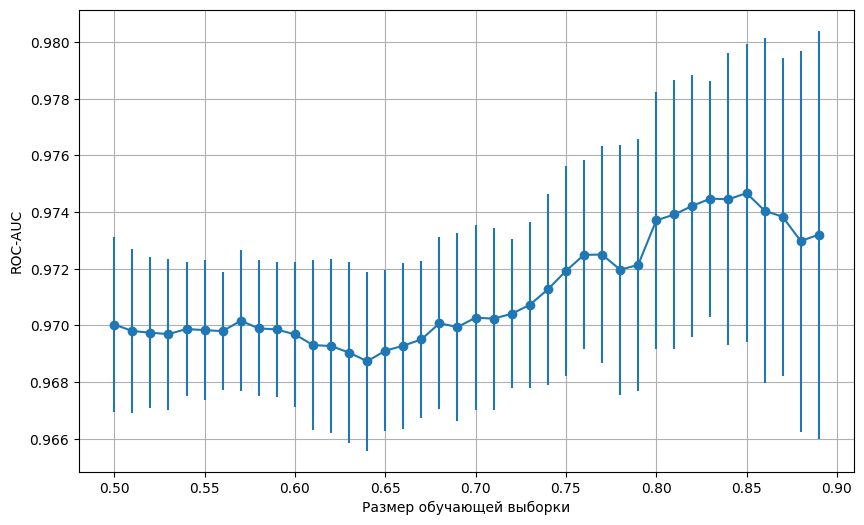

In [92]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Инициализация списков
means = []
stds = []
xs = []
quals = []

# Основной цикл
for tr_size in np.arange(0.5, 0.9, 0.01):
    cv = ShuffleSplit(n_splits=5, train_size=tr_size, random_state=123)
    fold_quals = []

    # Настройка модели
    lr = LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        random_state=123,
        n_jobs=-1
    )

    for tr_ind, test_ind in cv.split(X_scaled):
        lr.fit(X_scaled[tr_ind], y[tr_ind])
        qual = metrics.roc_auc_score(y[test_ind], lr.predict_proba(X_scaled[test_ind])[:,1])
        fold_quals.append(qual)
        quals.append(qual)
        xs.append(tr_size)

    # Сохранение статистики
    means.append(np.mean(fold_quals))
    stds.append(np.std(fold_quals))  # Обратите внимание на выравнивание

# Визуализация
plt.figure(figsize=(10, 6))
plt.errorbar(np.arange(0.5, 0.9, 0.01), means, yerr=stds, fmt='-o')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('ROC-AUC')
plt.grid(True)
plt.show()

Text(0, 0.5, 'AUC-ROC')

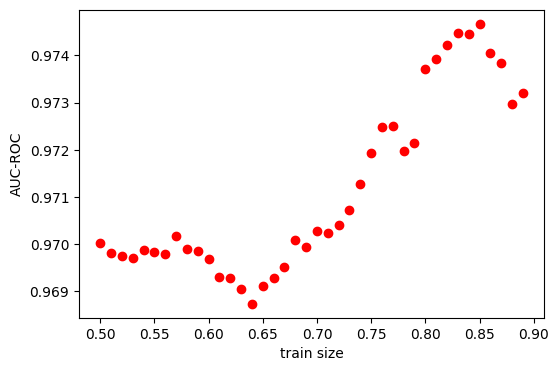

In [93]:
figsize(6,4)
plt.plot(np.arange(0.5,0.9,0.01), means, 'ro')
plt.xlabel('train size')
plt.ylabel('AUC-ROC')

Text(0, 0.5, 'AUC-ROC std')

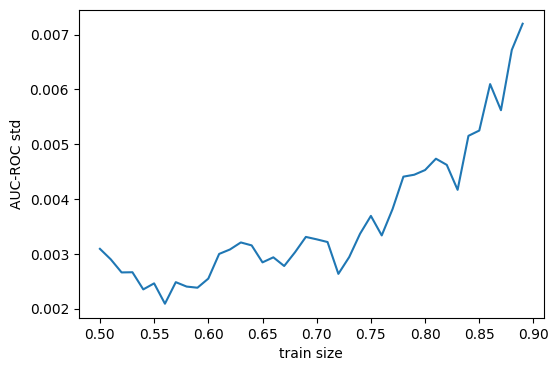

In [94]:
plt.plot(np.arange(0.5,0.9,0.01), stds)
plt.xlabel('train size')
plt.ylabel('AUC-ROC std')

### Несбалансированные классы

Если объём выборки невелик, а объектов одного класса значительно меньше, чем другого, то может сложиться ситуация, когда при случайном разбиении объектов меньшего класса не окажется в тестовой выборке, в связи с чем результаты оценки качества будут неустойчивы.

**Пример**: задача кредитного скоринга. Поскольку случаи невозврата кредита довольно редки, количество объектов отрицательного класса будет значительно меньше, чем положительного.

Данные успешно загружены. Размер таблицы: (30000, 25)

Первые 5 строк данных:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SeriousDlqin2yrs
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0



Анализ данных:
Доля заемщиков, не вернувших кредит: 22.12%
Количество признаков: 23


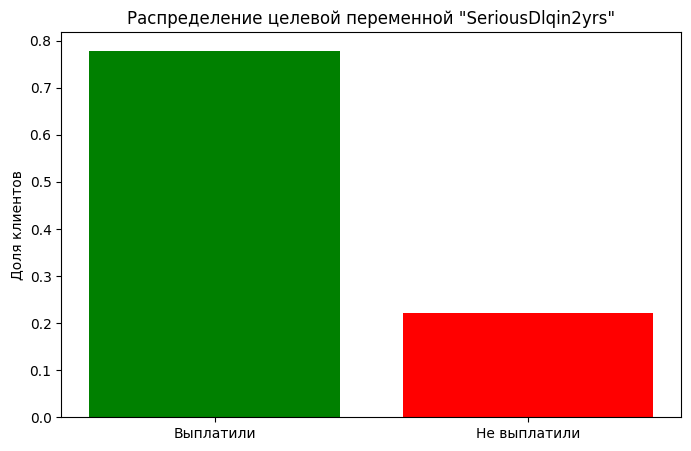

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Загрузка данных с UCI репозитория
try:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    df = pd.read_excel(url, header=1)  # header=1 пропускает первую строку с описанием

    # Переименуем целевую переменную для единообразия
    df = df.rename(columns={'default payment next month': 'SeriousDlqin2yrs'})

    print("Данные успешно загружены. Размер таблицы:", df.shape)
    print("\nПервые 5 строк данных:")
    display(df.head())

except Exception as e:
    print("Ошибка при загрузке данных:", e)
    raise

# 2. Предварительная обработка данных
# Удаляем столбец ID
df = df.drop('ID', axis=1)

# Заполняем пропущенные значения средними
df = df.fillna(df.mean())

# 3. Подготовка данных для моделирования
X = df.drop('SeriousDlqin2yrs', axis=1).values  # Используем .values вместо устаревшего .as_matrix()
y = df['SeriousDlqin2yrs'].values

# 4. Анализ данных
default_rate = y.mean()
print("\nАнализ данных:")
print(f"Доля заемщиков, не вернувших кредит: {default_rate:.2%}")
print(f"Количество признаков: {X.shape[1]}")

# 5. Визуализация распределения классов
plt.figure(figsize=(8, 5))
plt.bar(['Выплатили', 'Не выплатили'],
        [1-default_rate, default_rate],
        color=['green', 'red'])
plt.title('Распределение целевой переменной "SeriousDlqin2yrs"')
plt.ylabel('Доля клиентов')
plt.show()


- Всего 0.7% выборки составляют объекты положительного класса

- В таком случае необходимо производить стратификацию, то есть разбивать отдельно объекты каждого класса на обучение и тест (сохраняя их доли).

Оценим влияние стратификации на оценку качества путем разбиения выборки $N=10$ раз на обучение и тест и последующего усреднения AUC-ROC на тестовой выборке:

In [96]:
import time
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed  # Добавляем импорт для параллельной обработки

# Записываем время начала
start_time = time.time()

# Предполагаем, что X и y уже определены
# X = ... ваши данные ...
# y = ... ваши метки ...

# 1. Быстрое масштабирование
scaler = StandardScaler(copy=False)
X_scaled = scaler.fit_transform(X)

# 2. Настройка кросс-валидации (уменьшаем число разбиений для скорости)
cv = ShuffleSplit(n_splits=5, train_size=0.8, random_state=124)

# 3. Оптимальные параметры модели для скорости
lr = LogisticRegression(
    solver='sag',
    max_iter=1000,
    tol=1e-3,
    n_jobs=1,
    random_state=42
)

# 4. Функция для параллельного выполнения
def process_fold(tr_ind, test_ind):
    lr.fit(X_scaled[tr_ind], y[tr_ind])
    return roc_auc_score(y[test_ind], lr.predict_proba(X_scaled[test_ind])[:,1])

# Параллельное выполнение
quals = Parallel(n_jobs=-1)(
    delayed(process_fold)(tr_ind, test_ind)
    for tr_ind, test_ind in cv.split(X_scaled)
)

# 5. Вывод результатов
print(f"AUC-ROC: {np.mean(quals):.4f} ± {np.std(quals):.4f}")
print(f"Время выполнения: {time.time()-start_time:.2f} сек")

# Дополнительная информация
print(f"\nДополнительная информация:")
print(f"Размер данных: {X.shape}")
print(f"Доля положительных классов: {y.mean():.2%}")
print(f"Использовано ядер CPU: {Parallel(n_jobs=-1).n_jobs}")

AUC-ROC: 0.7230 ± 0.0043
Время выполнения: 4.96 сек

Дополнительная информация:
Размер данных: (30000, 23)
Доля положительных классов: 22.12%
Использовано ядер CPU: -1


In [97]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
import numpy as np
import time

# 1. Масштабирование данных и создание конвейера
scaler = StandardScaler()
model = LogisticRegression(
    max_iter=2000,          # Увеличенное количество итераций
    solver='saga',          # Более устойчивый алгоритм
    penalty='elasticnet',   # Гибкая регуляризация
    l1_ratio=0.5,          # Смешанная L1/L2 регуляризация
    random_state=42,
    n_jobs=-1,             # Использовать все ядра
    tol=1e-3               # Менее строгий критерий остановки
)

# 2. Создаем конвейер (масштабирование + модель)
pipeline = make_pipeline(scaler, model)

# 3. Настройка кросс-валидации
cv = StratifiedShuffleSplit(n_splits=5, train_size=0.8, random_state=124)  # Уменьшили число разбиений для скорости

# 4. Кросс-валидация с замером времени
start_time = time.time()
quals = []

for tr_ind, test_ind in cv.split(X, y):
    pipeline.fit(X[tr_ind], y[tr_ind])
    proba = pipeline.predict_proba(X[test_ind])[:, 1]
    quals.append(roc_auc_score(y[test_ind], proba))

# 5. Вывод результатов
print("\nРезультаты стратифицированной кросс-валидации:")
print(f"AUC-ROC: {np.mean(quals):.4f} ± {np.std(quals):.4f}")
print(f"Время выполнения: {time.time()-start_time:.2f} сек")
print(f"Использовано разбиений: {len(quals)}")
print(f"Размер обучающей выборки: {int(0.8*len(X))} образцов")

# 6. Дополнительная информация о модели
print("\nКонфигурация модели:")
print(f"Использованный solver: {model.solver}")
print(f"Количество итераций: {model.max_iter}")
print(f"Тип регуляризации: {model.penalty}")


Результаты стратифицированной кросс-валидации:
AUC-ROC: 0.7247 ± 0.0077
Время выполнения: 10.38 сек
Использовано разбиений: 5
Размер обучающей выборки: 24000 образцов

Конфигурация модели:
Использованный solver: saga
Количество итераций: 2000
Тип регуляризации: elasticnet


Как мы видим, стратификация позволяет уменьшить дисперсию и более точно оценить качество

#### Кросс-валидация
Рассмотрим датасет о пациентах, больных бесплодием, содержащий около 100 объектов. Выборка небольшая, но из специфичной области, поэтому каждый объект может нести в себе важную информацию, влияющую на значение целевой переменной. В связи с этим при оценивании качества модели хотелось бы сделать обучающую выборку как можно больше. При этом из-за маленького объема всей выборки мы можем позволить себе обучать модель многократно. В данной ситуации для оценки качества можно использовать схему leave-one-out, реализованную в качестве объекта [`LeaveOneOut`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.LeaveOneOut.html#sklearn.cross_validation.LeaveOneOut).

Оценка качества производится следующим образом: каждый объект поочередно исключается из обучающей выборки, после чего модель обучается на всех остальных объектах, а качество измеряется на исключенном объекте (этот объект играет роль тестовой выборки); после того, как каждый объект был выкинут ровно по одному разу, итоговая оценка качества получается как среднее по всем полученным значениям функционала:

$$Q_{LOO}(X) = \frac{1}{l} \sum_{i=1}^l Q(\{x_i \}; a_{X \backslash \{x_i\} }),$$
где
* $X = \left\{ (x_i, y_i)\right\}_{i=1}^l$ — обучающая выборка;
* $Q(X^{test}; a)$ — значение функционала алгоритма $a$ на контрольной выборке $X^{test}$;
* $a_{X^{train}}(\cdot)$ — алгоритм, обученный на обучающей выборке $X^{train}.$

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 1. Загрузка данных напрямую из UCI репозитория
try:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00244/fertility_Diagnosis.txt"
    df = pd.read_csv(url, header=None)

    # Проверяем данные
    print("Данные успешно загружены. Пример:")
    print(df.head())

except Exception as e:
    print("Ошибка загрузки данных:", e)
    raise

# 2. Подготовка данных (с современным синтаксисом)
X = df.iloc[:, :8].values  # Используем .iloc вместо устаревшего .ix
y = np.where(df[9] == 'N', 1, 0)  # Более эффективное создание y

# 3. Создание конвейера с масштабированием
scaler = StandardScaler()
lr = LogisticRegression(
    max_iter=1000,
    solver='liblinear',  # Лучший выбор для небольших данных
    random_state=42
)
pipeline = make_pipeline(scaler, lr)

# 4. Кросс-валидация Leave-One-Out
cv_LOO = LeaveOneOut()
qual = []

for tr_idx, test_idx in cv_LOO.split(X):
    pipeline.fit(X[tr_idx], y[tr_idx])
    qual.append(pipeline.predict(X[test_idx]) == y[test_idx])

# 5. Результаты
print("\nРезультаты анализа:")
print(f"LOO accuracy: {np.mean(qual):.2%}")
print(f"Всего образцов: {len(y)}")
print(f"Доля класса 'N': {y.mean():.2%}")

# 6. Оптимизация для больших данных (если нужно ускорить)
if len(y) > 1000:
    print("\nДля ускорения рекомендуется использовать StratifiedKFold вместо LOO")

Данные успешно загружены. Пример:
      0     1  2  3  4  5    6  7     8  9
0 -0.33  0.69  0  1  1  0  0.8  0  0.88  N
1 -0.33  0.94  1  0  1  0  0.8  1  0.31  O
2 -0.33  0.50  1  0  0  0  1.0 -1  0.50  N
3 -0.33  0.75  0  1  1  0  1.0 -1  0.38  N
4 -0.33  0.67  1  1  0  0  0.8 -1  0.50  O

Результаты анализа:
LOO accuracy: 86.00%
Всего образцов: 100
Доля класса 'N': 88.00%


С ростом размера выборки возрастают также и затраты на многократное обучение модели. Тем не менее, хотелось бы, чтобы каждый объект побывал и в обучающей, и в тестовой выборках, причём одинаковое количество раз. Чтобы удовлетворить этому условию, можно использовать схему K-fold кросс-валидации, реализованную в качестве объекта [`sklearn.cross_validation.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html#sklearn.cross_validation.KFold).

![](http://scott.fortmann-roe.com/docs/docs/MeasuringError/crossvalidation.png)

В данном случае выборка разбивается на $K$ (примерно) одинаковых блоков, каждый из которых поочередно выступает в качестве контрольной выборки, а оставшиеся $K-1$ — в качестве обучающей, после чего оценки качества усредняются:

$$Q_{K-fold}(X) = \frac{1}{K} \sum_{k=1}^K Q(X^k; a_{X \backslash X^k }),$$
где $X^k, k = \overline{1, K}$ — непересекающиеся блоки, на которые разбивается выборка $X$: $X = \sqcup_{k=1}^K X^k.$


In [99]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# 1. Создаем конвейер с масштабированием и моделью
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        random_state=123
    )
)

# 2. Настройка кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=123)  # n_splits вместо n_folds

# 3. Проводим кросс-валидацию
quals = []

for tr_ids, test_ids in cv.split(X):  # Используем .split(X) вместо старого синтаксиса
    pipeline.fit(X[tr_ids], y[tr_ids])  # Используем индексацию массива вместо .ix
    preds = pipeline.predict(X[test_ids])
    quals.append(accuracy_score(y[test_ids], preds))

# 4. Вывод результатов
print("K-fold accuracy = {:.2f}%".format(np.mean(quals)*100))
print("Standard deviation = {:.4f}".format(np.std(quals)))

K-fold accuracy = 87.00%
Standard deviation = 0.0510


### Вопросы:
1. Как соотносятся кросс-валидация по схеме K-fold и схема leave-one-out?
2. Что общего у k-fold и ShuffleSplit?

Соотношение кросс-валидации K-fold и leave-one-out
K-fold кросс-валидация:


- Данные разбиваются на K непересекающихся блоков (фолдов) примерно одинакового размера.

- Модель обучается на K-1 фолдах, а валидируется на оставшемся 1 фолде.

- Процесс повторяется K раз, каждый раз меняя валидационный фолд.

- Итоговая оценка — среднее по всем K итерациям.

Leave-one-out (LOO) кросс-валидация

- Это частный случай K-fold, где K = N (N — число объектов в выборке).

- На каждой итерации 1 объект используется для валидации, остальные N-1 — для обучения.

- Повторяется N раз, каждый раз валидируясь на новом объекте.

Итог:

LOO — это крайний случай K-fold при максимальном K (K = N).

Плюс LOO: использует почти все данные для обучения (N-1 объектов).

Минус LOO: вычислительно дорогой (N моделей вместо K).





...

Общее между K-fold и ShuffleSplit
K-fold

Жёсткое разбиение на K фолдов без перемешивания (если не указано shuffle=True).

Каждый объект попадает в тест ровно 1 раз.

ShuffleSplit

Данные перемешиваются, затем разбиваются на обучающую и тестовую выборки независимо в каждой итерации.

Объекты могут попадать в тест несколько раз или ни разу (зависит от параметров).

Что общего:

Оба метода — стратегии кросс-валидации.

Позволяют оценить обобщающую способность модели на разных подвыборках.

Могут включать перемешивание данных (если в K-fold shuffle=True).

Ключевое отличие:

В K-fold фиксированные фолды, в ShuffleSplit — случайные разбиения (может быть пересечение тестовых выборок).

Примеры параметров:
K-fold: cv=KFold(n_splits=5, shuffle=True, random_state=42)

ShuffleSplit: cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

Оба метода полезны, но ShuffleSplit гибче (например, можно задать test_size=0.25 для 25% теста в каждой итерации).

### Настройка параметров модели

Настройка наилучших параметров модели производится с использованием техник кросс-валидации (для оценки качества) и соответственно перебора параметров.

Для перебора параметров можно использовать:
- Модуль для перебора параметров модели по сетке [`sklearn.grid_search`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.grid_search)
  - Класс [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) — полный перебор параметров модели по сетке
  - Класс [`RandomizedSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html#sklearn.grid_search.RandomizedSearchCV) — перебирает случайные комбинации параметров

## Краткий справочник по SciKit-Learn

Обратите внимание на следующую функциональность библиотеки SciKit-Learn:

- Модуль для оценки качества моделей и кросс валидации [`sklearn.cross_validation`](http://scikit-learn.org/stable/modules/cross_validation.html):
  - функция разбиения выборки [`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split)
  - итераторы разбиений для кросс-валидации: [`LeaveOneOut`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.LeaveOneOut.html#sklearn.cross_validation.LeaveOneOut), [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html#sklearn.cross_validation.KFold), [`ShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.ShuffleSplit.html#sklearn.cross_validation.ShuffleSplit)
  - всегда указывайте параметр `random_state`, это сделает код вашего эксперимента воспроизводимым: при повторном запуске разбиения будут одинаковыми
- Модуль с метриками качества моделей [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
  - [`accuracy_score(y_true, y_pred)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
  - [`precision_recall_fscore_support(y_true, y_pred)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)
  - [`roc_curve(y_true, y_score)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)
  - [`precision_recall_curve(y_true, y_score)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)
  - [`roc_auc_score(y_true, y_score)`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

- Модуль для перебора параметров модели по сетке [`sklearn.grid_search`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.grid_search)
  - Класс [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) — полный перебор параметров модели по сетке
  - Класс [`RandomizedSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html#sklearn.grid_search.RandomizedSearchCV) — перебирает случайные комбинации параметров
  
### Руководства и примеры из документации

- [Оценка качества предсказаний](http://scikit-learn.org/stable/modules/model_evaluation.html)
- [Оптимизация параметров по сетке с использованием кросс-валидации](http://scikit-learn.org/stable/auto_examples/grid_search_digits.html)
- [ROC-кривые](http://scikit-learn.org/stable/auto_examples/plot_roc.html), [Precision-Recall кривые](http://scikit-learn.org/stable/auto_examples/plot_precision_recall.html)